# Thickness and refractive index recovery for calibration samples
This notebook uses the recovered camera CMFs and a LUT to try to obtain the thickness and refractive index of a set of calibration PMMA on Si samples

## Data requierements

 - An npy file containing the spectra of the samples to process
 - An npy file containing the measured rgb values of the samples to process
 - An npy file containing the CMFs of the camera
 - An npy file containing the LUT
 - Dispersion tables for PMMA and Si in CSV format

## Theory

The reflection spectra of a PMMA layer on a Si wafer can be computed analytically using the transfer matrix method (TMM) if the thickness and dispersion curves of the PMMA and Si are known. Different combinations of thicknesses and dispersion curves result in different spectra and therefore different colors when the sample is viewed through a camera. Given a photo of a sample and the CMFs of a camera an inverse search can be performed for the spectra that most closely reproduces the color of the photo. This program does exactly that.

### Note about normalization

The TMM routine produces theoretical spectra that are normalized (i.e. reflection spectra assuming a uniform illumination of 1 across the visible). Because the photos are taken with a non-ideal source it is necessary to make a correction to make the theoretical and measured spectra equivalent. If the camera CMFs were recovered using normalized spectra then this correction has already been implemented and no action is necessary. 

### Import dependencies and locate data

In [1]:
import os
import re

import imageio
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import scipy.optimize as opt
from joblib import Parallel, delayed
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from tmm.tmm_core import coh_tmm
from tqdm import tqdm

# ==== User selected parameters === #

project_dir = r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current works/Biocolors/code/Arturo/"

spectra_vec = np.load(r"./Metadata/v5_sam_spectra_lu.npy")
rgb_vec = np.load(r"./Metadata/v5_sam_rgb_lu.npy")
CMFs = np.load(r"./Metadata/v5_CCD_CMFs_lu.npy")
# CMFs = np.load(r"./Archived/v2_CCD_CMFs_lu.npy")
meas_thick = np.loadtxt(r"./Metadata/thickABE.csv", delimiter=",", usecols=1)
dvec = np.load("./Metadata/Si_LUT_dvec_sml.npy")
nvec = np.load("./Metadata/Si_LUT_nvec_sml.npy")
LU_LUT = np.load("./Metadata/Si_LU_LUT_until_140-170_sml.npy")

lams = CMFs[:, 0]
True_n = 1.48

# disp_folder = project_dir + r"../Camera_calibration_samples/Dispersions/"
# Si_disp_file = r"./c-Si_HJY_dispersion.txt"
# PMMA_disp_file = r"./PMMA_dispersion_setA.txt"

# === Readable font size in plots == #

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({"font.size": 16})
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.fonttype"] = 42

## Define sample class

In [2]:
class Sample:
    """This class stores and processes the experimental data of a sample

    Attributes:
        - name [str] : Name of the sample
        - spectra [1D array]: Intensity values of the sample spectra
        - rgb [3D array]: Pixel values of the sample photo
        - disp [1D array]: Intensity valus of the dispersion curve

    Methods:
        - get_norm_spectra(): Returns raw_spectra/mirr_spectra

    """

    def __init__(self, name, spectra, rgb, thick):
        # Store data
        self.name = name
        self.spectra = spectra
        self.rgb = rgb
        self.thick = thick

In [3]:
# Get ordered file list of the sample directory
disp_folder = "/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Dispersions/"
dispfilelist = sorted(
    os.listdir(disp_folder),
    key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)],
)

# Obtain the .txt files subset (ignore any other file like .DS_storage)
disp_file_names = [file for file in dispfilelist if file.endswith(".txt")]

# Extract sample names
sample_names = []
for file in tqdm(disp_file_names):
    sample_names.append(file.split("_")[0])

sample_names = sample_names[:51] + sample_names[91:]  # Retain only ABE samples
print(sample_names)

100%|███████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 216158.38it/s]

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'E1', 'E2', 'E3', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']


In [4]:
# === Create sample objects for the different materials === #
PMMA_samples = []
# SiN_samples = []
# SiO2_samples = []
AZ1505_samples = []

for q, name in enumerate(sample_names):
    if ("A" in name) or ("B" in name):
        PMMA_samples.append(Sample(name, spectra_vec[q], rgb_vec[q], meas_thick[q]))
    # if "C" in name:
    #     coefs = all_dsp_lst[q]
    #     disp = np.array(
    #         [
    #             NAM_disp(lam, coefs[0], coefs[1], coefs[2], coefs[3], coefs[4])
    #             for lam in lams
    #         ]
    #     )
    #     SiN_samples.append(
    #         Sample(name, spectra_vec[q], rgb_vec[q], meas_thick[q], disp)
    #     )
    # if "D" in name:
    #     coefs = all_dsp_lst[q]
    #     disp = np.array([hartman(lam, coefs[0], coefs[1], coefs[2]) for lam in lams])
    #     SiO2_samples.append(
    #         Sample(name, spectra_vec[q], rgb_vec[q], meas_thick[q], disp)
    #     )
    if "E" in name:
        AZ1505_samples.append(Sample(name, spectra_vec[q], rgb_vec[q], meas_thick[q]))

all_samples = PMMA_samples + AZ1505_samples  # + SiN_samples + SiO2_samples

## Si TMM functions

In [5]:
Si_disp = np.loadtxt(r"./c-Si_HJY_dispersion.txt", skiprows=4)


def Si_n(wl0):
    """Returns the complex refractive index of crystalline Si at a given wavelenth
    from tabulated data

    Inputs:
        wl0- Wavelenght

    Output:
        n+ik - refractive index value"""
    wl, n, k = Si_disp[:, 0], Si_disp[:, 1], Si_disp[:, 2]
    return np.interp(wl0, wl, n) + 1j * np.interp(wl0, wl, k)


def get_ref_spectra_d_ndisp(wavs, d, disp):
    """Computes the reflection amplitude for 's' polarized light using TMM at a
    multiple wavelengths for single layer of material with constant refractive index on Si

    Inputs:
        wavs [array] - Vector of wavelengths in nm
        d [float] - thickness [nm]
        disp [array] - refractive index values at each wavelength, must match wavs vector
    Output:
        coh_tmm reflection [array] - Amplitude value"""

    reflection = np.zeros(wavs.shape)
    d_list = [np.inf, d, 500000, np.inf]  # Air, layer, Si, Air
    for q, n in enumerate(disp):
        wl0 = wavs[q]
        nk_list = [1, n, Si_n(wl0), 1]
        reflection[q] = coh_tmm("s", nk_list, d_list, 0, wl0)["R"]
    return reflection


def spec2rgb_d_n(d, n):
    """Compute RGB values for a simulated film on Si spectra"""
    spectra = get_ref_spectra_d_ndisp(lams, d, np.ones(lams.shape) * n)
    rgb_pred = np.array(
        [
            np.trapz(spectra * CMFs[:, 1]),
            np.trapz(spectra * CMFs[:, 2]),
            np.trapz(spectra * CMFs[:, 3]),
        ]
    )
    return rgb_pred

# Image analysis

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys

sys.path.append("./src/")

import imageio
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import photo_analysis_functions as src
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from tmm.tmm_core import coh_tmm
from tqdm import tqdm

In [8]:
# sam1 = all_samples[13]
sam1 = all_samples[23]

print(sam1.name, sam1.rgb, sam1.thick, "true n=1.484")

B3 [1355.31068334 7276.72038792 2031.01206092] 362.8 true n=1.484


In [9]:
spec2rgb_d_n(sam1.thick, 1.482)

array([1843.75972015, 6923.31453473, 1711.84092796])

In [13]:
photo_file = (
    r"/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/True final samples/Camera calibration/"
    + sam1.name
    + "_LU.tif"
)
raw_photo = imageio.v2.imread(photo_file)

main_colors, reduced_photo, color_labels = src.reduce_colors(raw_photo, 2)
np.mean(np.abs((raw_photo-reduced_photo)))

132.3210662558965

In [14]:
src.cluster_variation(rawphoto=raw_photo, main_colors=main_colors, pixel_labels=color_labels)



Cluster 0, 19551480 pixels, central RGB:[1326.87693238 7185.65116983 2007.42566076]
Avg variation from centroid:
14 bits [112.92700247 188.19420971 122.92093774]
8 bits [1.76448441 2.94053453 1.92063965]
Avg variation across channels from centroid:
14 bits 141.34738330761152
8 bits 2.20855286418143. or 0.863%


Cluster 1, 4891656 pixels, central RGB:[ 26.77218493 145.43671204  76.70933639]
Avg variation from centroid:
14 bits [ 25.96083591 176.68120851  86.089183  ]
8 bits [0.40563806 2.76064388 1.34514348]
Avg variation across channels from centroid:
14 bits 96.24374247452528
8 bits 1.5038084761644575. or 0.587%


Global max percent error: 0.863


In [29]:
err=np.empty(5)
raw_photo = imageio.v2.imread(photo_file)

for q in range(5):
    main_colors, reduced_photo, color_labels = src.reduce_colors(raw_photo, q+1)
    err[q]=np.mean(np.abs((raw_photo-reduced_photo)))

plt.plot(np.arange(5)+1,err)
plt.show()

KeyboardInterrupt: 

In [11]:
print(main_colors)

[[1326.87506608 7185.64246292 2007.42370519]
 [  26.7668869   145.4024295    76.69820716]]


20it [00:06,  2.99it/s]


Found RGB: [1335.06502671 6949.11912388 2013.38357529]


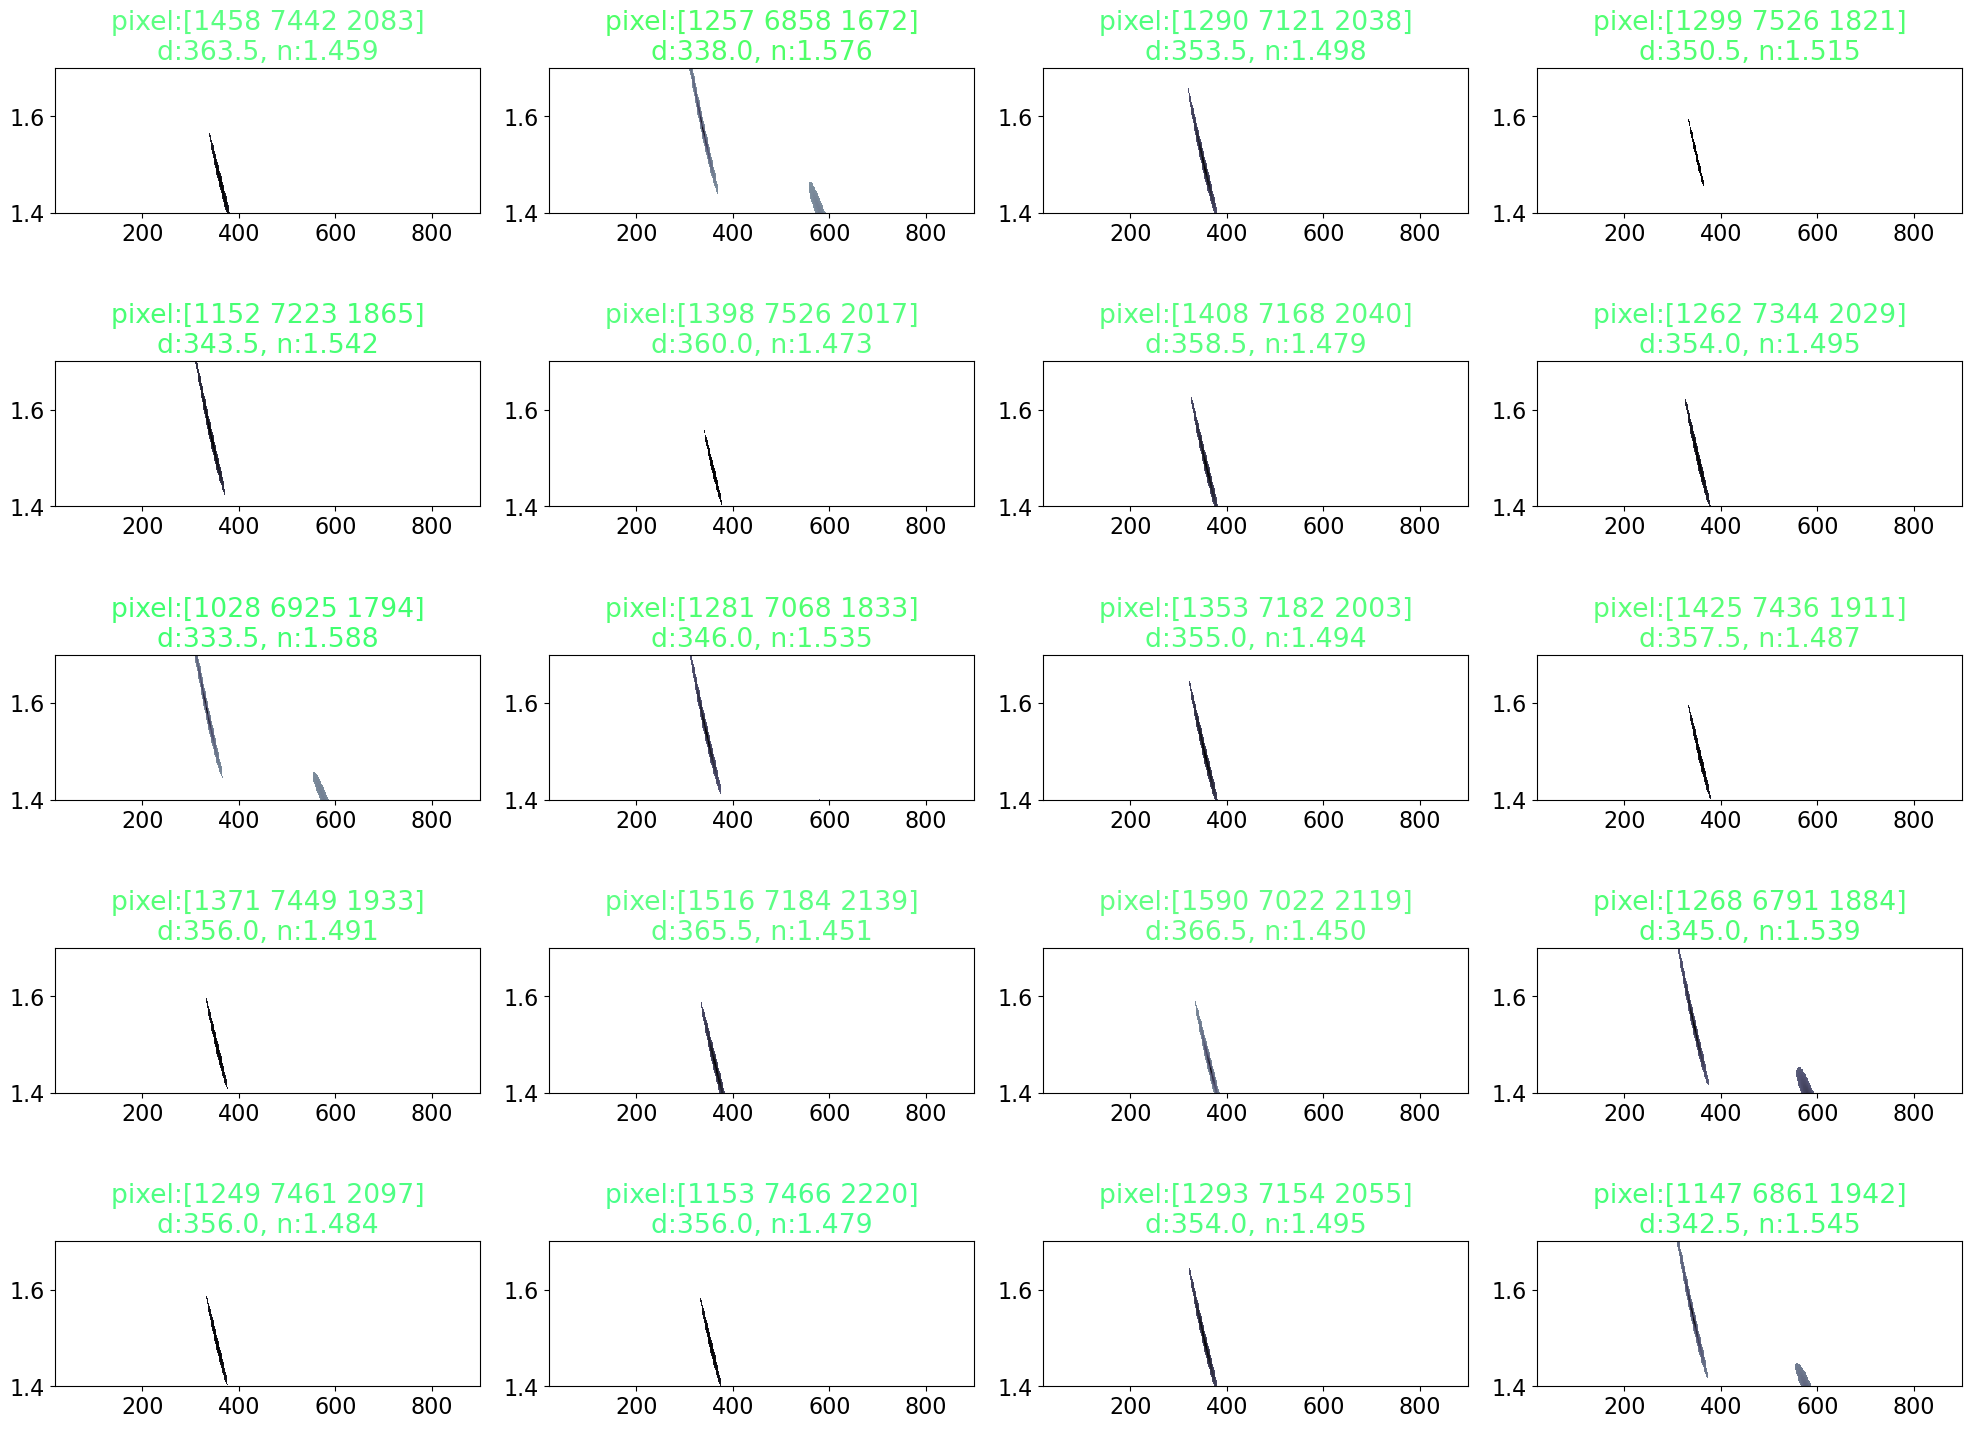

Confidence in thickness minima:  1.0
Confidence in RI minima:  1.0


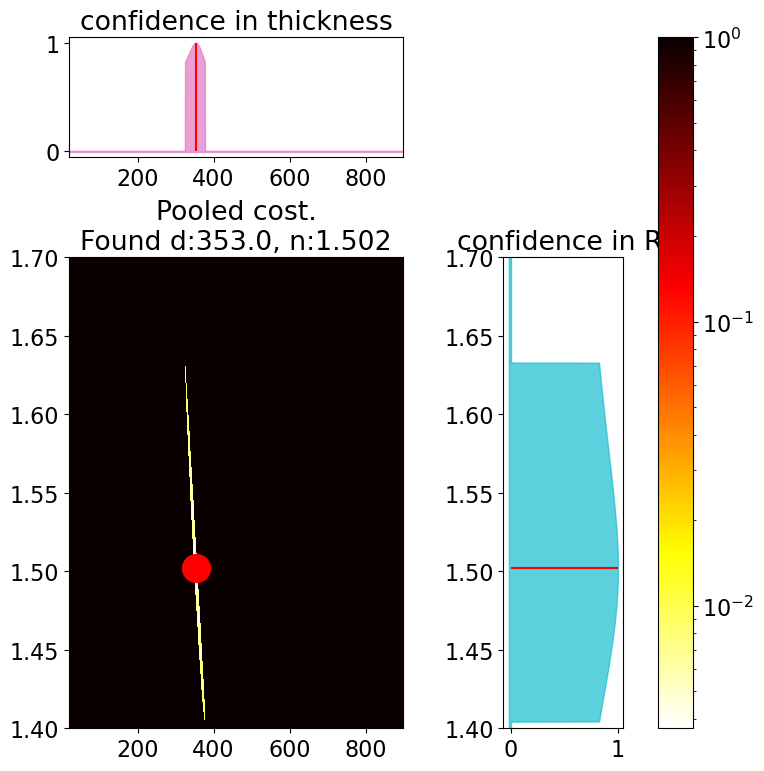

In [25]:
_, _, _, cost_grayb = src.cluster_map_recoveryb(
    LU_LUT,
    dvec,
    nvec,
    raw_photo,
    color_labels,
    cluster_idx=0,
    num_pixels=4 * 5,
    th=.01,
    plot_subsample=3,
    saveplots=False,
)

Reducing image to 2 clusters
Computing thickness and refractive index values for 2 color clusters in parellel


100it [00:31,  3.21it/s]
100it [00:37,  2.64it/s]
/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/code/Arturo/./src/photo_analysis_functions.py:209: RuntimeWarning: invalid value encountered in true_divide
  conf_d /= conf_d.max()
/home/burguea/Dropbox (KAUST)/Primalight_shared/Current_works/Biocolors/code/Arturo/./src/photo_analysis_functions.py:217: RuntimeWarning: invalid value encountered in true_divide
  conf_n /= conf_n.max()
/home/burguea/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


[[  26.76680887  145.40021453   76.69760656]
 [1326.87488611 7185.64193683 2007.4235592 ]]
[[ 932.31934794  787.90515477 1100.7052477 ]
 [1310.13123638 6949.01072109 2028.95551688]]
Creating reconstructed RI and thickness maps images...


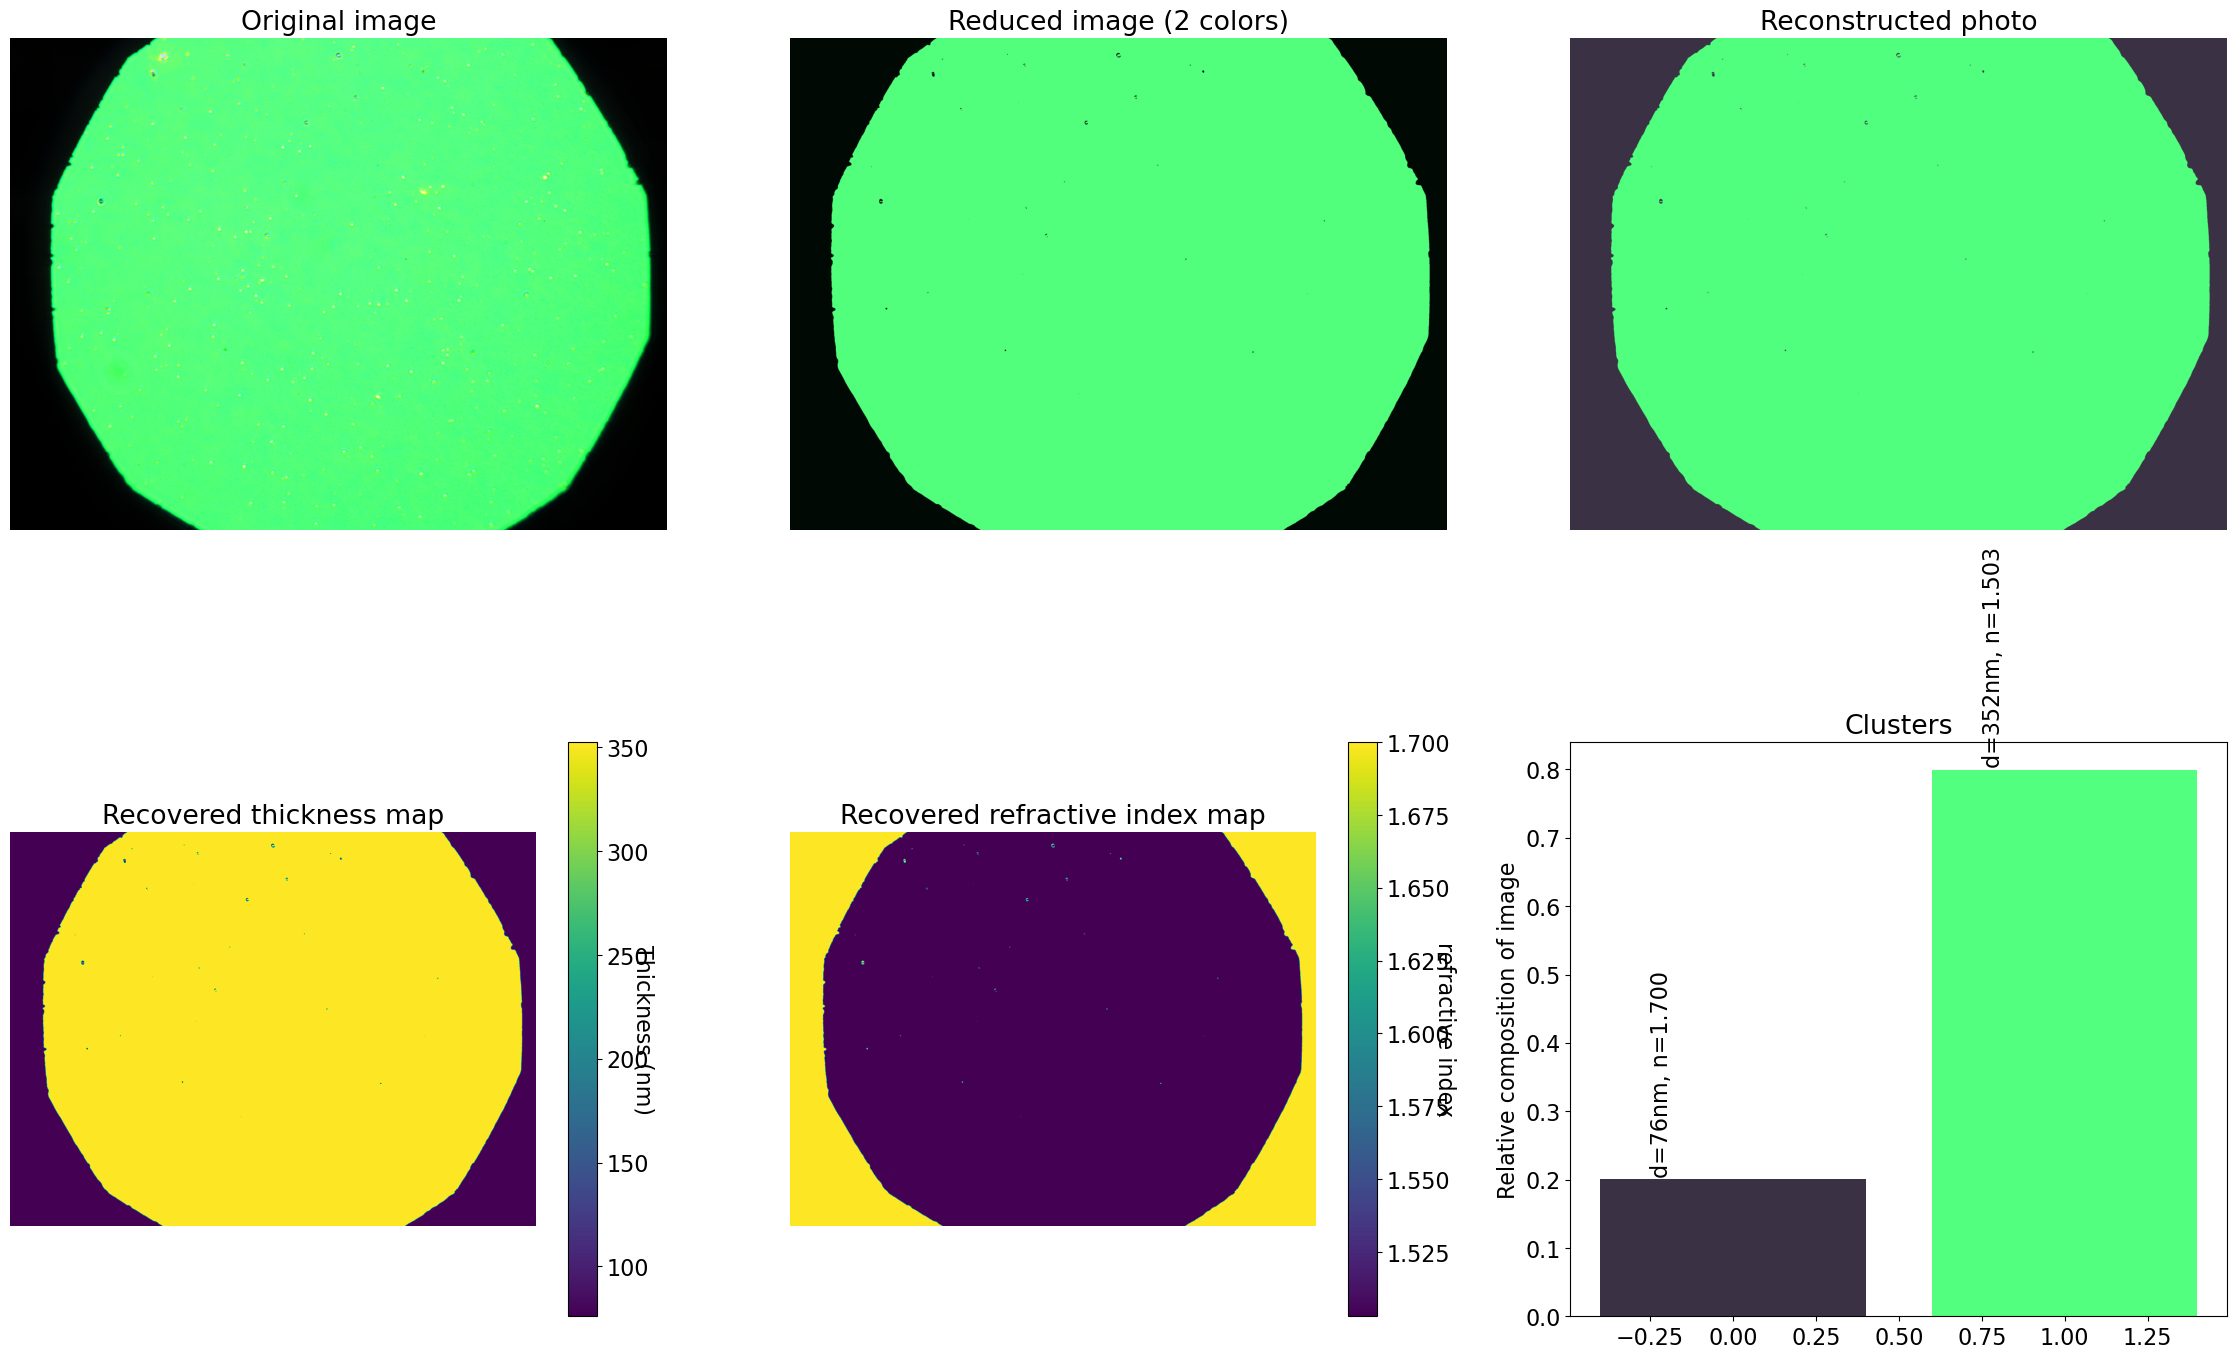

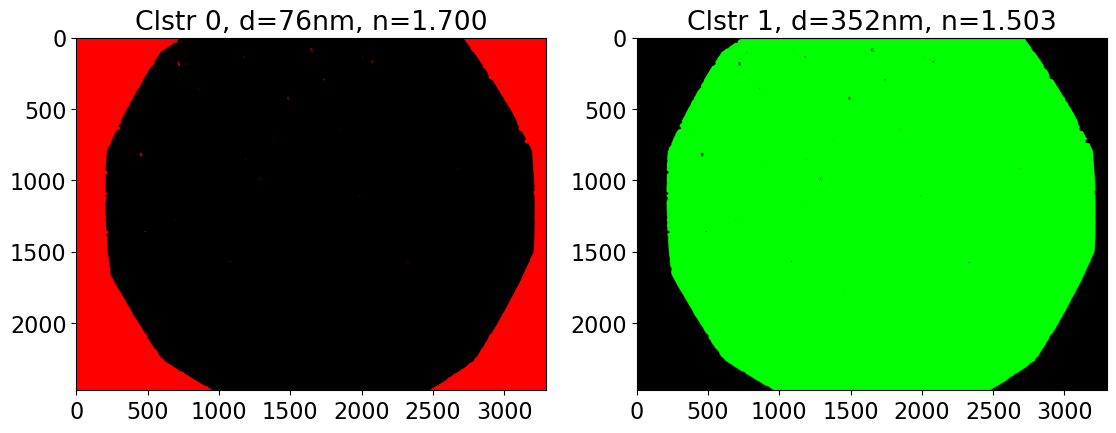

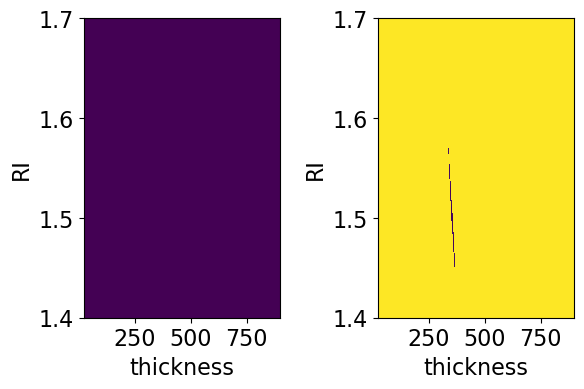

Found RGB: [1310.13123638 6949.01072109 2028.95551688]
Figure(2000x7500)
Figure(800x800)
Found RGB: [ 932.31934794  787.90515477 1100.7052477 ]
Figure(2000x7500)
Figure(800x800)


In [112]:
src.full_photo_analysis(
    LU_LUT, dvec, nvec, 100, photo_file, 2, th=0.01, plot_subsample=3
)

## Metameric samples

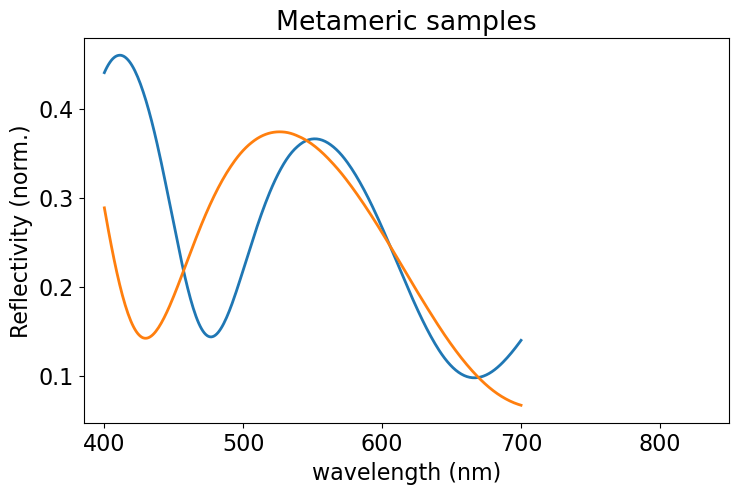

In [26]:
spec1 = get_ref_spectra_d_ndisp(lams, d=588, disp=np.ones(lams.shape) * 1.414)
spec2 = get_ref_spectra_d_ndisp(lams, d=356, disp=np.ones(lams.shape) * 1.496)

plt.figure(figsize=(5 / 3 * 5, 5))
plt.plot(lams, spec1, lw=2)
plt.plot(lams, spec2, lw=2)
plt.xlim(right=850)
plt.xlabel("wavelength (nm)")
plt.ylabel("Reflectivity (norm.)")
plt.title("Metameric samples")
plt.savefig("./other_plots/metamers.pdf", bbox_inches="tight", transparent=True)
plt.show()

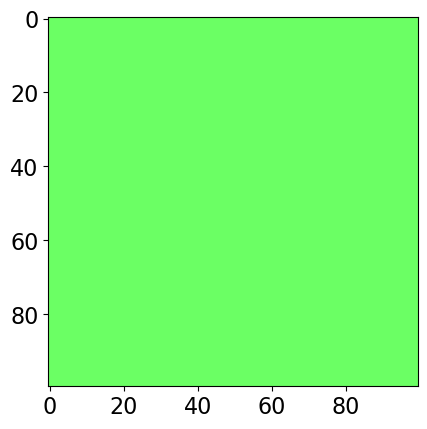

In [27]:
s1img = np.ones((100, 100, 3)) * np.array([1727, 6366, 1615])

plt.imshow(src.make_displayable(s1img))

4it [00:01,  2.53it/s]


Found RGB: [1690.88770461 6284.51728742 1689.25664495]


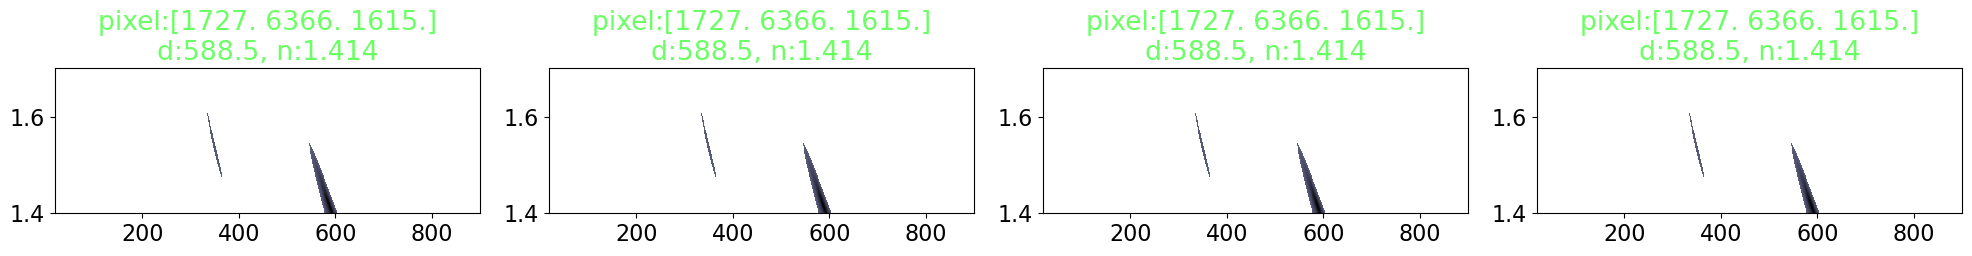

Confidence in thickness minima:  0.6174700972923964
Confidence in RI minima:  0.6174700972923964


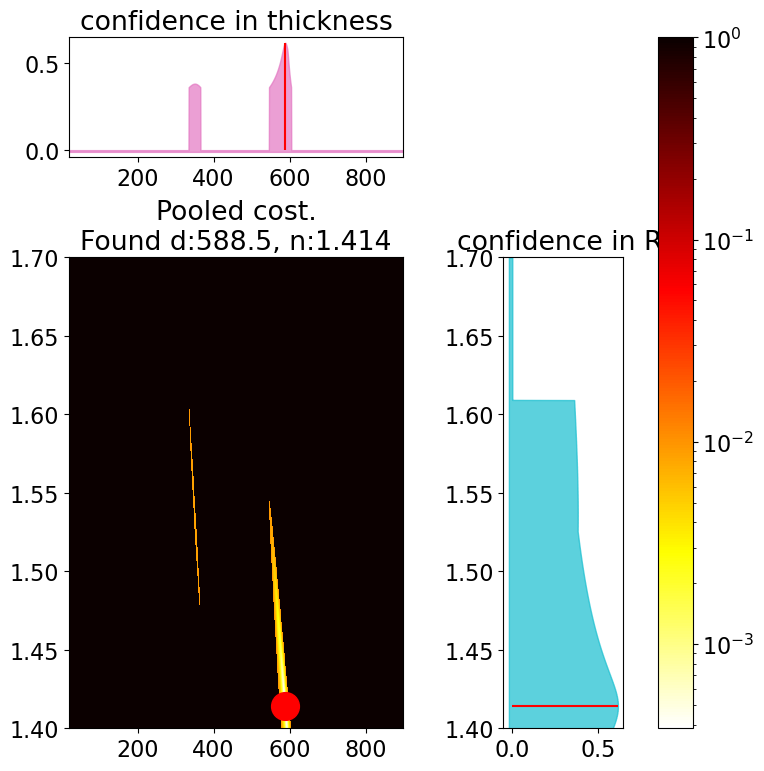

In [28]:
main_colors, reduced_photo, color_labels = src.reduce_colors(s1img, 1)
_, _, _, cost_grayb = src.cluster_map_recoveryb(
    LU_LUT,
    dvec,
    nvec,
    s1img,
    color_labels,
    cluster_idx=0,
    num_pixels=4 ,
    th=.01,
    plot_subsample=2,
    saveplots=False,
)